In [1]:
import os
import glob
import cv2
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# 训练集文件夹路径
train_path = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*"

# 测试集文件夹路径
test_path = "GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*"

In [3]:
# 默认显示前5个类别的文件夹路径
glob.glob(train_path)[:5]

['GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00028',
 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000',
 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00011',
 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00007',
 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00026']

In [4]:
# 按照比例： train 70%, val 20%, test 10% 创建文件夹，将每个类别的图片按此比例分配

# 第一步：分别创建train, val, test下各个类别的文件夹

classes_path = sorted(glob.glob(train_path)) # 所有类别的文件夹路径
categories = ['train', 'val', 'test'] # 分别创建3个文件夹
new_data_dir = Path('NEW_DATA') # 新数据集目录

for cat in categories:
    for path in classes_path:
        class_name = path[-5:] # 类别名称即为文件夹名称的最后5位数字
        (new_data_dir/cat/class_name).mkdir(parents=True, exist_ok=True)

In [5]:
# 第二步：将原始train下的各个类别的图片按照比例保存到新建的文件夹下

class_indices = np.arange(len(classes_path)) # 所有类别对应的索引

#print(class_indices)

for i, class_idx in enumerate(class_indices):
    img_paths = np.array(sorted(glob.glob(f'{classes_path[int(class_idx)]}/*.ppm'))) # 图片路径
    class_name = classes_path[i][-5:]# 类别名称
    # 打乱图片路径
    np.random.shuffle(img_paths)
    # 索引分割 70%, 20%, 10%
    paths_split = np.split(img_paths, indices_or_sections=[int(0.7 * len(img_paths)), int(0.9 * len(img_paths))])
    for ds, pathes in zip(categories, paths_split):
        for path in pathes:
            shutil.copy(path,f'{new_data_dir}/{ds}/{class_name}')

In [6]:
# 根据路径，加载图片
def load_img(img_path, resize=True):
    image = cv2.imread(img_path) # 根据路径，加载图片
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA) # 颜色转换
    if resize==True:
        image = cv2.resize(image, (64, 64))
    return image

In [7]:
# 根据路径，显示图片
def show_img(img_path):
    img = load_img(img_path) # 加载图片
    plt.imshow(img) # 显示图片
    plt.axis('off') # 关闭坐标轴

In [8]:
# 随机获取一张图片的路径，并显示

class_0_paths = np.array(sorted(glob.glob(f'{classes_path[0]}/*.ppm'))) # 索引0对应的类别的所有图片路径

random_img_path = np.random.choice(class_0_paths)

print(random_img_path)

GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00004_00029.ppm


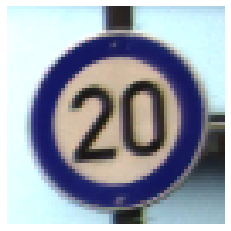

In [9]:
show_img(random_img_path)

### 数据增强

In [10]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
import torch
from torch import nn, optim
from collections import defaultdict

In [11]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size=256), # 随机裁剪
        transforms.RandomRotation(degrees=15), # 随机旋转
        transforms.RandomHorizontalFlip(), # 随机水平翻转
        transforms.ToTensor(), # 转换为tensor
        transforms.Normalize(mean_nums, std_nums)
    ]),
    
    'val' : transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    
    'test' : transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ])
}

In [12]:
# 数据文件对象
image_folders = {
    k : ImageFolder(f'{new_data_dir}/{k}', transform[k]) for k in categories
}

In [13]:
# 数据加载器
dataloaders = {
    k : DataLoader(image_folders[k], batch_size=32, shuffle=True, num_workers=12, pin_memory=True) for k in categories
}

In [14]:
# train，val，test 大小
data_sizes = {
    k : len(image_folders[k]) for k in categories
}

In [15]:
# 类别名称
names = image_folders['train'].classes

In [16]:
data_sizes

{'train': 27439, 'val': 7849, 'test': 3921}

In [17]:
# 显示一组图片
def imshow(imgs, title=None):
    imgs = imgs.numpy().transpose((1, 2, 0)) # 类型转换，交换维度顺序
    means = np.mean([mean_nums]) # 均值
    stds = np.mean([std_nums]) # 标准差
    imgs = imgs * stds + means # 复原
    imgs = np.clip(imgs, 0, 1) # 将像素限制在0-1之间
    plt.imshow(imgs)
    if title:
        plt.title(title)
    plt.axis('off')

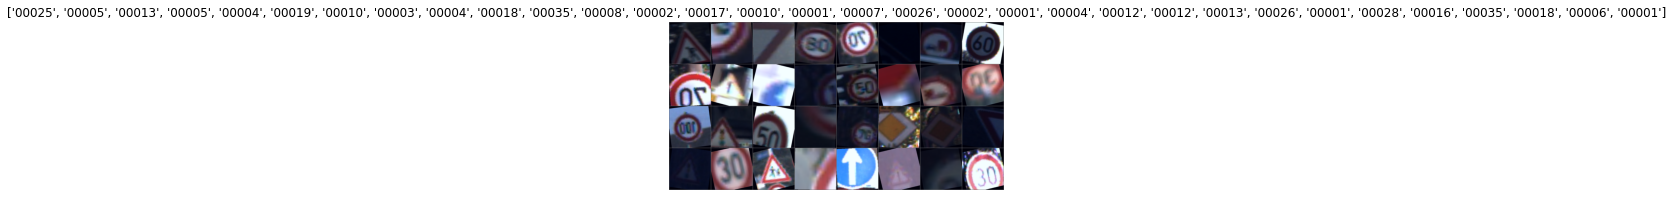

In [18]:
# 显示train中一批数据 1个batch_size
inputs, labels = next(iter(dataloaders['train']))

group_imgs = make_grid(inputs)

imshow(group_imgs, title=[names[i] for i in labels])

### 迁移学习

In [19]:
def create_model(n_classes):
    """获取预训练模型
    n_classes : 类别数量
    """
    model = models.resnet50(pretrained=True)
    n_features = model.fc.in_features # 全连接层的特征
    #新的特征输出
    model.fc = nn.Linear(n_features, n_classes)
    
    return model

In [20]:
# 创建模型对象
new_model = create_model(len(names)) # 有多少个类别，就有多少个输出

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

new_model = new_model.to(device)

In [42]:
# 训练函数
def train(model, data_loader, criterion, optimizer, scheduler, n_examples, device):
    model.train()
    optimizer.zero_grad() # 梯度置零
    losses = []
    correct_predictions = 0
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs) # 输出
        loss = criterion(outputs, targets) # 计算损失
        _, preds = torch.max(outputs, dim=1) # 获取最大概率值的下标
        correct_predictions += torch.sum( preds == targets) # 累计判断正确的数量
        losses.append(loss.item()) # 累计损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数、
    scheduler.step() # 学习率自动调整
    return np.mean(losses), correct_predictions / n_examples

In [43]:
# 验证函数
def val(model, data_loader, criterion, n_examples, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs) # 预测输出
            loss = criterion(outputs, targets) # 计算损失
            _, preds = torch.max(outputs, dim=1) # 获取最大概率值下标
            correct_predictions += torch.sum( preds == targets) # 累计判断正确的数量
            losses.append(loss.item()) # 累计损失
    return np.mean(losses), correct_predictions / n_examples

In [44]:
def train_val_model(model, data_loader, dataset_sizes, device, epochs=10):
    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # 自动调节学习率
    criterion = nn.CrossEntropyLoss() # 损失函数
    history = defaultdict(list) # 保存结果
    best_accuracy = 0 # 最好的准确率
    best_model = None # 最好的模型
    for epoch in range(epochs):
        print(f'{epoch + 1} / {epochs}')
        train_loss, train_accuracy = train(model, dataloaders['train'], criterion, optimizer,
                                           scheduler, data_sizes['train'], device)
        print(f'Train Loss : {train_loss}, Train Acc : {train_accuracy}')
        
        eval_loss, eval_accuracy = val(model, dataloaders['val'], criterion, data_sizes['val'], device)
        print(f'Eval Loss : {eval_loss}, Eval Acc : {eval_accuracy}')
        
        # 保存结果
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['eval_acc'].append(eval_accuracy)
        history['eval_loss'].append(eval_loss)
        
        # 比较：获取最好得分和模型
        if best_accuracy < eval_accuracy:
            torch.save(model.state_dict(), 'best_model_state.pth')
            best_accuracy = eval_accuracy
        
    print("最好模型验证得分： ", best_accuracy)
    
    # 加载模型
    model.load_state_dict(torch.load("best_model_state.pth"))
    
    return model, history

In [45]:
best_model, history = train_val_model(new_model, dataloaders, data_sizes, device)

1 / 10
Train Loss : 7.555529162322447, Train Acc : 0.04369692876935005
Eval Loss : 6.954497982815998, Eval Acc : 0.02879347838461399
2 / 10
Train Loss : 5.441930296259883, Train Acc : 0.0411822609603405
Eval Loss : 4.568614590458754, Eval Acc : 0.027392026036977768
3 / 10
Train Loss : 4.494735069486089, Train Acc : 0.05069426819682121
Eval Loss : 6.494058988927826, Eval Acc : 0.054401837289333344
4 / 10
Train Loss : 4.228720153406227, Train Acc : 0.06541784107685089
Eval Loss : 6.538343846313352, Eval Acc : 0.06370238214731216
5 / 10
Train Loss : 3.958169104336025, Train Acc : 0.07729873806238174
Eval Loss : 4.157611147174991, Eval Acc : 0.058988407254219055
6 / 10
Train Loss : 4.19610950190982, Train Acc : 0.0836765244603157
Eval Loss : 4.674576765153466, Eval Acc : 0.09580838680267334
7 / 10
Train Loss : 3.7621708041304474, Train Acc : 0.09074675291776657
Eval Loss : 3.8771785904721514, Eval Acc : 0.1337750107049942
8 / 10
Train Loss : 3.6140297101094174, Train Acc : 0.09501075744628

### 模型2

In [46]:
def create_model_2(n_classes):
    """获取预训练模型
    n_classes : 类别数量
    """
    model = models.resnet50(pretrained=True)
    # 冻结模型参数
    for param in model.parameters():
        param.requires_grad = False
    # 替换全连接层
    model.fc = nn.Sequential(
        nn.Flatten(), # 拉平
        nn.BatchNorm1d(2048), # 正则化
        nn.Dropout(0.5), 
        nn.Linear(2048, 512),
        nn.ReLU(), # 激活函数
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, 43),
        nn.LogSoftmax(dim=1)
    )
    return model

In [47]:
new_model_2 = create_model_2(len(names)).to(device) # 新模型

In [48]:
new_model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
best_model2, history2 = train_val_model(new_model_2, dataloaders, data_sizes, device, epochs=30)

1 / 30
Train Loss : 5.014600295009035, Train Acc : 0.2465468943119049
Eval Loss : 144.68224071390262, Eval Acc : 0.31086763739585876
2 / 30
Train Loss : 8.144561888454678, Train Acc : 0.23798245191574097
Eval Loss : 217.5533090432485, Eval Acc : 0.2623264193534851
3 / 30
Train Loss : 8.813787166888897, Train Acc : 0.23379133641719818
Eval Loss : 382.1468956296037, Eval Acc : 0.3451395034790039
4 / 30
Train Loss : 8.697500312244976, Train Acc : 0.23335400223731995
Eval Loss : 102.70717729010234, Eval Acc : 0.34169960021972656
5 / 30
Train Loss : 7.918827001031462, Train Acc : 0.230219766497612
Eval Loss : 392.72173070374544, Eval Acc : 0.33214423060417175
6 / 30
Train Loss : 6.354385445445845, Train Acc : 0.24272023141384125
Eval Loss : 187.20947773669792, Eval Acc : 0.3615747392177582
7 / 30
Train Loss : 6.111009990974462, Train Acc : 0.24067933857440948
Eval Loss : 86.18371295541283, Eval Acc : 0.4079500734806061
8 / 30
Train Loss : 5.387485666430636, Train Acc : 0.3090127408504486
Ev

In [59]:
# 绘制loss, acc
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.plot(history['train_loss'], label="train loss")
    ax1.plot(history['eval_loss'], label="eval loss")
    #ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")

    ax2.plot(history['train_acc'], label="train acc")
    ax2.plot(history['eval_acc'], label="eval acc")
    #ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    fig.suptitle("Train and Val history")

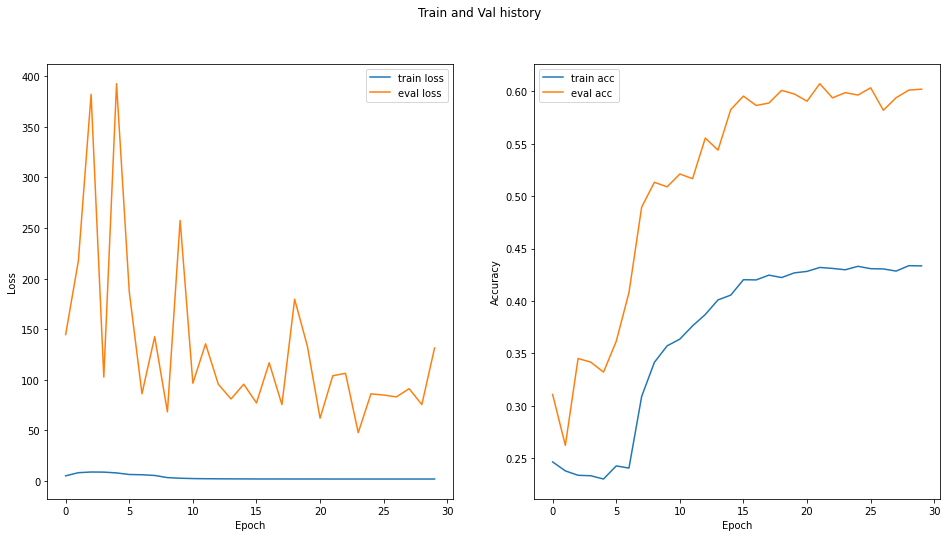

In [61]:
plot_history(history2)

为什么 验证集准确度 大于 训练集准确度？

原因1：数据集太小，造成训练集和测试集的分布不均匀，造成训练集内部方差大于验证集，因而误差更大。
措施1：（1）扩充数据集；（2）重新切分数据集，使其分布均匀。

原因2：由dropout引起，它基本上能够确保测试准确性最好，优于训练集的准确性。